In [ ]:
import os
import itertools
import time
import random
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Bidirectional, Dense, Masking
from tensorflow.keras.optimizers import Adam


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU device not found. Đảm bảo bạn đã chọn runtime GPU.")
else:
    print(f"Found GPU at: {device_name}")

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [ ]:
def flattern(p):
    pred_y_matrix = [[] for _ in range(len(p[0]))]
    for pp in p:
        a = pp.tolist()
        for m in range(len(a)):
            pred_y_matrix[m] += a[m]
    return pred_y_matrix


def interpolate(data, mask=-1):
    temp = [list(dd) for dd in data]
    d = []
    for i in range(len(temp)):
        # biến mask thành NaN để interpolate
        arr = [np.nan if x == mask else x for x in temp[i]]
        df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
        d.append(df.tolist())
    return d


def data_split(dat, train_hour, test_hour, predict_position, stride):
    x, y = [], []
    period = train_hour + predict_position + test_hour
    i = 0
    length = len(dat[0])
    while i + period <= length:
        x_temp, y_temp = [], []
        for series in dat:
            x_temp.append(series[i : i + train_hour])
            y_temp.append(series[
                i + train_hour + predict_position :
                i + train_hour + predict_position + test_hour
            ])
        x.append(x_temp)
        y.append(y_temp)
        i += stride
    return np.array(x), np.array(y)


def split_train(int_dat, norm_dat, T1, T2, T3, stride, start, end, data_name=None):
    length = len(int_dat[0])
    s = int(length * start)
    e = int(length * end)

    # X train: normalize toàn bộ (loại đoạn test s:e), X test: lấy interpolate trên bản int_dat
    Train = [serie[:s] + serie[e:] for serie in norm_dat]
    Test = [serie[s:e] for serie in int_dat]

    print(f'Training series length: {len(Train[0])}; Test series length: {len(Test[0])}')
    train_x, train_y = data_split(Train, T1, T2, T3, stride)
    test_x, test_y = data_split(Test,  T1, T2, T3, stride)
    return train_x, train_y, test_x, test_y


def data_normalize(Dat, mask=-1):
    new_dat = []
    scaling = []
    for d in Dat:
        valid = [v for v in d if v != mask]
        mn = np.min(valid) if valid else 0
        mx = np.max(valid) if valid else 1
        normed = [(v - mn) / (mx - mn) if v != mask and mx != mn else v
                  for v in d]
        new_dat.append(normed)
        scaling.append((mn, mx))
    return new_dat, scaling


In [ ]:
def load_and_align_data(sensor_files, variables, mask=-1):
    data = []
    variable_names = []
    time_index = None

    # Tìm giao time_index
    for _, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        time_index = df.index if time_index is None else time_index.intersection(df.index)

    # Đọc lại từng sensor theo time_index chung
    for name, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        for var in variables:
            if var in df:
                series = df.loc[time_index, var].tolist()
                data.append(series)
                variable_names.append(f"{name}_{var}")

    return data, variable_names, time_index

def stacked_LSTM(X, Y, lstm_units=[32,], lr=1e-5):
    timesteps, n_features = X.shape[1], X.shape[2]
    out_dim = Y.shape[2]

    model = Sequential([
        Masking(mask_value=-1., input_shape=(timesteps, n_features)),
        Bidirectional(LSTM(lstm_units[0], activation='relu', return_sequences=True)),
        # nếu muốn thêm layer nữa, uncomment dưới
        # Bidirectional(LSTM(lstm_units[1], activation='relu', return_sequences=True)),
        Dense(out_dim)
    ])
    model.compile(
        loss='mean_absolute_error',
        optimizer=Adam(learning_rate=lr)
    )
    early_stop = EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    # ép GPU nếu có
    import tensorflow as tf
    with tf.device('/GPU:0'):
        hist = model.fit(
            X, Y,
            epochs=50,
            batch_size=10,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

    model.summary()
    return model, hist


def SP_Learner(data, train_time, predict_time, predict_position, stride, start, end, data_name):
    # chuẩn hóa và interpolate
    norm_dat, scaling = data_normalize(data)
    interp_dat = interpolate(norm_dat, mask=-1)

    # tạo train/test sets
    train_x, train_y, test_x, test_y = split_train(
        interp_dat, norm_dat,
        train_time, predict_time, predict_position,
        stride, start, end, data_name
    )

    # train model
    model, hist = stacked_LSTM(train_x, train_y)
    pred_y = model.predict(test_x, verbose=1)

    return pred_y, test_y, model, scaling

In [ ]:
def evaluate_model(pred_y, test_y, variable_names, scaling_params, time_index, start):
    results = {}
    for i, var in enumerate(variable_names):
        mn, mx = scaling_params[i]
        # reshape về 1d để evaluate
        pred_flat = pred_y[:, i, 0].ravel() * (mx - mn) + mn
        true_flat = test_y[:,i,0].ravel() * (mx - mn) + mn

        # xác định time axis
        s = int(len(time_index) * start)
        dates = pd.date_range(
            start=time_index[s],
            periods=len(pred_flat),
            freq=time_index[1] - time_index[0]
        )

        # tìm shift tối ưu
        metrics = []
        for sh in range(-20,1):
            sp = np.roll(pred_flat, sh)
            if sh<0: sp[sh:] = sp[sh-1]
            mae  = mean_absolute_error(true_flat, sp)
            rmse = np.sqrt(mean_squared_error(true_flat, sp))
            r2   = r2_score(true_flat, sp)
            mape = mean_absolute_percentage_error(true_flat+1e-10, sp+1e-10)*100
            metrics.append((sh, mae, rmse, r2, mape))
        best = min(metrics, key=lambda x: x[1])
        sh, mae0, rmse0, r20, mape0 = best

        plt.figure(figsize=(12,5))
        plt.plot(dates, np.roll(pred_flat, sh), label=f'Pred (shift {sh})')
        plt.plot(dates, true_flat, label='True')
        plt.legend(); plt.title(var); plt.tight_layout(); plt.show()

        print(f"\n{var} -> MAE:{mae0:.4f}, RMSE:{rmse0:.4f}, R²:{r20:.4f}, MAPE:{mape0:.2f}% (shift={sh})")

        results[var] = {
            'MAE': mae0, 'RMSE': rmse0, 'R2': r20, 'MAPE': mape0, 'shift': sh
        }
    return results

In [ ]:
# Configuration settings
train_time = 325       # Training sequence length
predict_time = 4      # Prediction sequence length
predict_position = 12 # Gap between training and prediction
stride = 3            # Stride for sequence generation
start = 0.8            # Training data proportion
end = 1.0              # Test data proportion
variables = ['PM2_5.ug.m3.']  # Target variable(s) to extract from each sensor


# Model Hyperparameter
learning_rate = 1e-5      # Learning rate for Adam optimizer
patience = 15             # Early stopping patience
epochs = 50               # Maximum training epochs
batch_size = 16           # Training batch size
lstm_units = 32

# Base path for sensor data files
base_path = '/content/1mins/'

# Define all sensor files
all_sensors = {
    'sensor1': f'{base_path}01_15mins.csv',
    'sensor2': f'{base_path}02_15mins.csv',
    'sensor3': f'{base_path}03_15mins.csv',
    'sensor4': f'{base_path}04_15mins.csv'
}
# all_sensors = {
#     'sensor1': f'{base_path}LASER PULSE- PAM Air Trích xuất dữ liệu Quý IV 2022.csv.xlsx - Trường THCS An Lạc.csv',
#     'sensor2': f'{base_path}LASER PULSE- PAM Air Trích xuất dữ liệu Quý IV 2022.csv.xlsx - Trường THCS Lê Minh Xuân.csv',
#     'sensor3': f'{base_path}LASER PULSE- PAM Air Trích xuất dữ liệu Quý IV 2022.csv.xlsx - Trường Tiểu học An Lạc 2.csv',
#     # 'sensor4': f'{base_path}LASER PULSE- PAM Air Trích xuất dữ liệu Quý IV 2022.csv.xlsx - Trường Tiểu học Cầu Xáng.csv'
# }

In [15]:
# Configuration settings
train_time = 335       # Training sequence length
predict_time = 30      # Prediction sequence length
predict_position = 70 # Gap between training and prediction
stride = 15            # Stride for sequence generation
start = 0.8            # Training data proportion
end = 1.0              # Test data proportion
variables = ['PM2_5.ug.m3.']  # Target variable(s) to extract from each sensor

# Base path for sensor data files
base_path = '/content/15mins/'

all_sensors = {
    'sensor1': f'{base_path}01_15mins.csv',
    'sensor2': f'{base_path}02_15mins.csv',
    'sensor3': f'{base_path}03_15mins.csv',
    'sensor4': f'{base_path}04_15mins.csv'
}


Processing all sensors together
Loaded 4 variables from sensors: sensor1, sensor2, sensor3, sensor4
Variables: ['sensor1_PM2_5.ug.m3.', 'sensor2_PM2_5.ug.m3.', 'sensor3_PM2_5.ug.m3.', 'sensor4_PM2_5.ug.m3.']
Training series length: 6260; Test series length: 1565
Epoch 1/50


<ipython-input-3-84a91d9f3334>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 0.1942 - val_loss: 0.1212
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1917 - val_loss: 0.1171
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1791 - val_loss: 0.1133
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1699 - val_loss: 0.1097
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1764 - val_loss: 0.1063
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1595 - val_loss: 0.1033
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1581 - val_loss: 0.1007
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1568 - val_loss: 0.0982
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1546 - val_loss: 0.0961
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1445 - val_loss: 0.0942
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1513 - val_loss: 0.0925
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1384 - val_loss: 0.090

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 4, 335)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 4, 64)          │        94,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4, 30)          │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,476 (1.10 MB)

 Trainable params: 96,158 (375.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,318 (751.25 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step


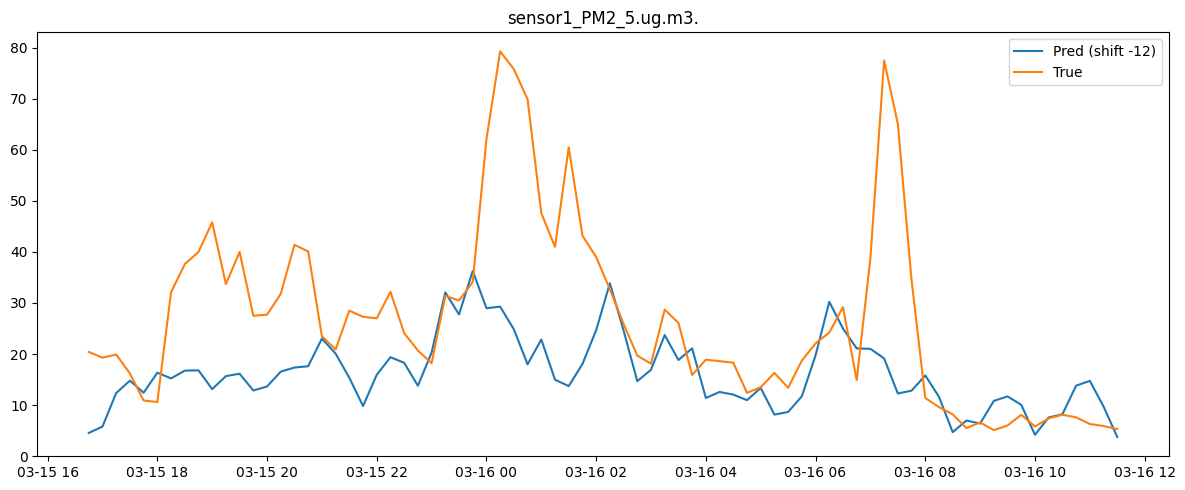


sensor1_PM2_5.ug.m3. -> MAE:12.3529, RMSE:18.8899, R²:-0.1153, MAPE:37.30% (shift=-12)


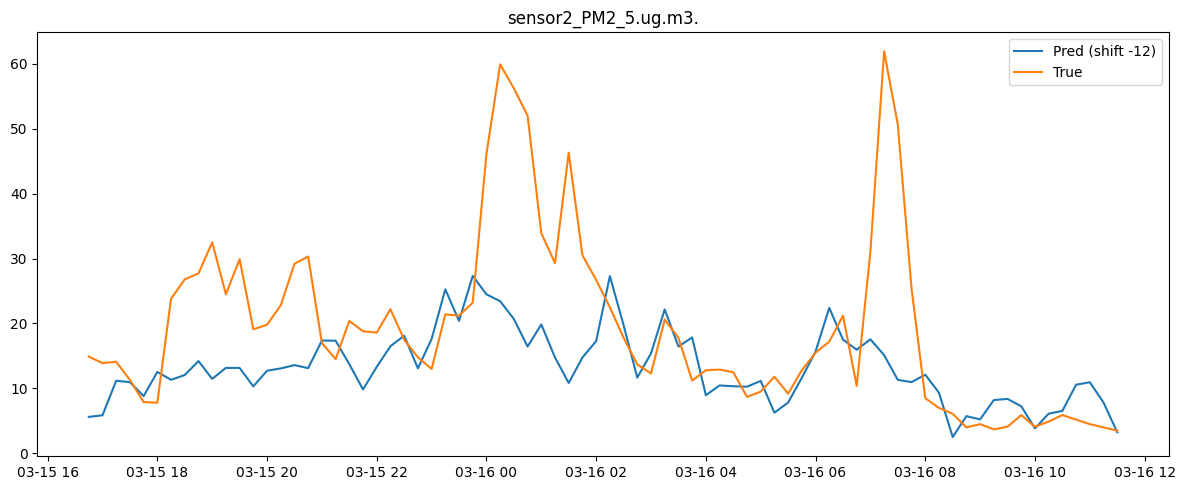


sensor2_PM2_5.ug.m3. -> MAE:8.4437, RMSE:13.2582, R²:0.0512, MAPE:37.33% (shift=-12)


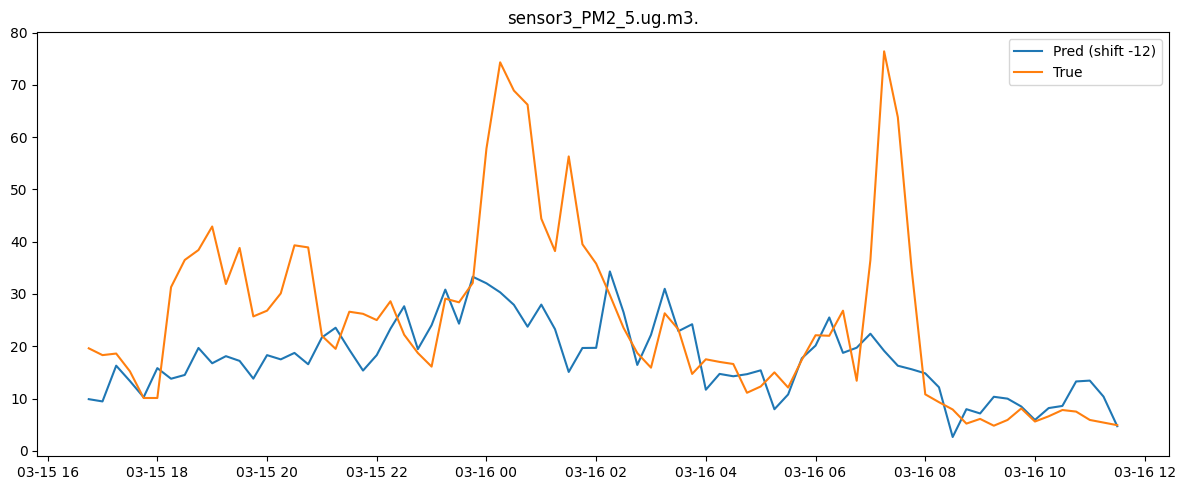


sensor3_PM2_5.ug.m3. -> MAE:10.6617, RMSE:16.2402, R²:0.0855, MAPE:38.63% (shift=-12)


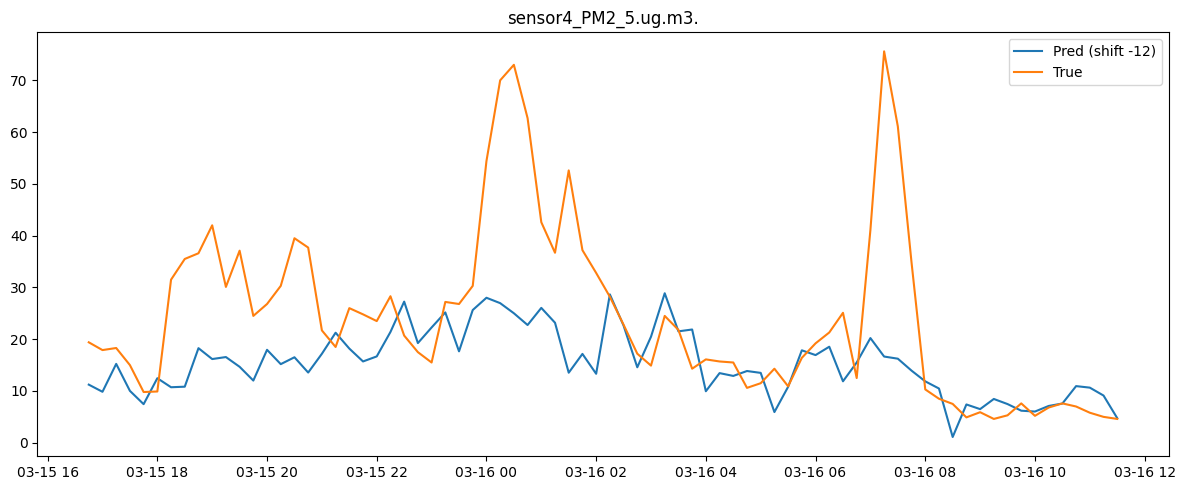


sensor4_PM2_5.ug.m3. -> MAE:11.2385, RMSE:16.7414, R²:-0.0112, MAPE:44.23% (shift=-12)
Results for all sensors: {'sensor1_PM2_5.ug.m3.': {'MAE': 12.352941659764435, 'RMSE': np.float64(18.889870754122462), 'R2': -0.11528791865634203, 'MAPE': 37.30181795884036, 'shift': -12}, 'sensor2_PM2_5.ug.m3.': {'MAE': 8.443712338398358, 'RMSE': np.float64(13.25819537773444), 'R2': 0.05120259481328604, 'MAPE': 37.33019374470674, 'shift': -12}, 'sensor3_PM2_5.ug.m3.': {'MAE': 10.661711544012897, 'RMSE': np.float64(16.24022522904357), 'R2': 0.08546697357404387, 'MAPE': 38.63073412064769, 'shift': -12}, 'sensor4_PM2_5.ug.m3.': {'MAE': 11.238505212308253, 'RMSE': np.float64(16.741378505619455), 'R2': -0.01121578469297524, 'MAPE': 44.22675613952004, 'shift': -12}}


In [16]:

# Store results cho mô hình dùng cả 4 sensor
all_sensor_results = {}

print(f"\n{'='*50}")
print("Processing all sensors together")
print(f"{'='*50}")

# Dùng toàn bộ 4 sensor
sensor_files = all_sensors

# Load aligned data
data, variable_names, time_index = load_and_align_data(sensor_files, variables)

if not data:
    print("No valid data found for all sensors. Exiting.")
else:
    print(f"Loaded {len(data)} variables from sensors: {', '.join(sensor_files.keys())}")
    print("Variables:", variable_names)

    # Train model và lấy dự đoán
    pred_y, test_y, model, scaling_params = SP_Learner(
        data,
        train_time,
        predict_time,
        predict_position,
        stride,
        start,
        end,
        'AirQuality_AllSensors'
    )

    # Đánh giá model
    results = evaluate_model(
        pred_y,
        test_y,
        variable_names,
        scaling_params,
        time_index,
        start
    )

    # Lưu kết quả
    all_sensor_results['all_sensors'] = results

# Sau đó bạn có thể in hoặc plot all_sensor_results['all_sensors']
print("Results for all sensors:", all_sensor_results['all_sensors'])